# Golden signal based RCA for sockshop

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from collections import defaultdict, OrderedDict
import pathlib

import numpy as np
import pandas as pd
import torch
import torchinfo
import scipy.stats
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', FutureWarning)

import sys
sys.path.append("../")

In [4]:
from notebooklib.save import run_tsdr, save_tsdr, load_tsdr

DATASET_ID = "qknmc"
datasets_fluxrank_max_cluster = load_tsdr(DATASET_ID, suffix="fluxrank_max_cluster", revert_normalized_time_series=True)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
from meltria.priorknowledge.priorknowledge import SockShopKnowledge

pk = SockShopKnowledge(
    target_metric_types={
        "containers": True,
        "services": True,
        "middlewares": True,
        "nodes": False,
    },
    mappings={"nodes-containers": {}},
)

In [5]:
import networkx as nx

from diagnoser import diag

def build_pc(data_df, pk, ci_alpha=0.05, draw=False):
    cg, (root_contained_graphs, root_uncontained_graphs), stats = diag.build_causal_graph(
        data_df, pk,
        pc_library="pcalg",
        pc_variant="stable",
        pc_citest="fisher-z",
        pc_citest_alpha=ci_alpha,
        disable_orientation=False,
        disable_ci_edge_cut=False,
    )
    return cg

def pagerank(cg: nx.Graph, record):
    pr = nx.pagerank(cg, alpha=0.85, weight="_weight")
    _records = []
    for metric_name, rank in pr.items():
        _records.append(
            (DATASET_ID, record.target_app(), record.chaos_type(), record.chaos_comp(), record.chaos_case_num(), str(metric_name), record.data_df[str(metric_name)].values, rank)
        )
    return _records

def build_pc_and_pagerank(record, data_df, ci_alpha):
    cg = build_pc(data_df, record.pk, ci_alpha)
    return cg, pagerank(cg, record)

In [28]:
from diagnoser import diag

data_df = datasets_fluxrank_max_cluster[10][-1]
cg, (root_contained_graphs, root_uncontained_graphs), stats = diag.build_causal_graph(
    data_df, pk,
    pc_library="pcalg",
    pc_variant="stable",
    pc_citest="fisher-z",
    pc_citest_alpha=0.05,
    disable_orientation=False,
    disable_ci_edge_cut=False,
)

orders/pod-memory-hog/0


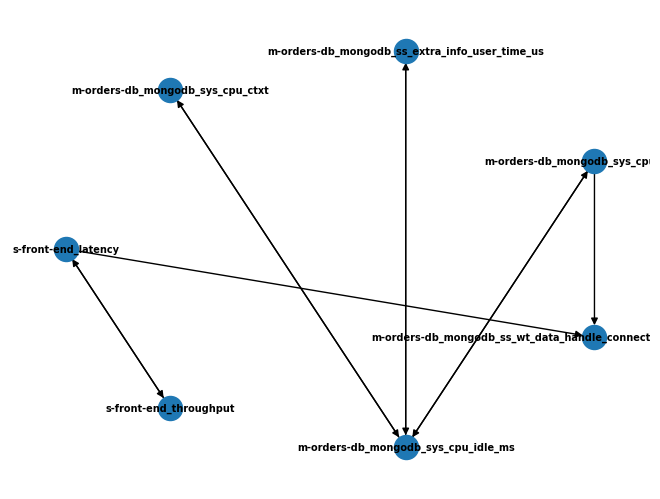

In [29]:
import networkx as nx

print(datasets_fluxrank_max_cluster[10][0].chaos_case_full())
nx.draw(cg, with_labels=True, font_weight='bold', font_size=7, pos=nx.shell_layout(cg))

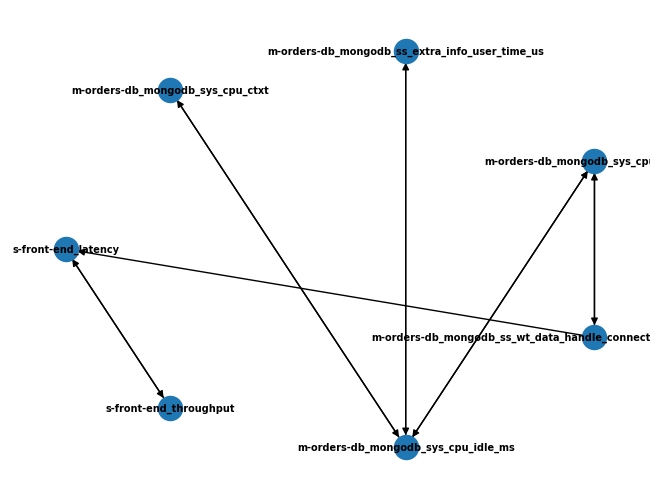

In [47]:
fixed_cg = diag.fix_edge_directions_in_causal_graph(cg, pk)
nx.draw(fixed_cg, with_labels=True, font_weight='bold', font_size=7, pos=nx.shell_layout(cg))

In [30]:
data_df = datasets_fluxrank_max_cluster[20][-1]
cg2, (root_contained_graphs2, root_uncontained_graphs2), stats2 = diag.build_causal_graph(
    data_df, pk,
    pc_library="pcalg",
    pc_variant="stable",
    pc_citest="fisher-z",
    pc_citest_alpha=0.05,
    disable_orientation=False,
    disable_ci_edge_cut=False,
)

front-end/pod-memory-hog/0


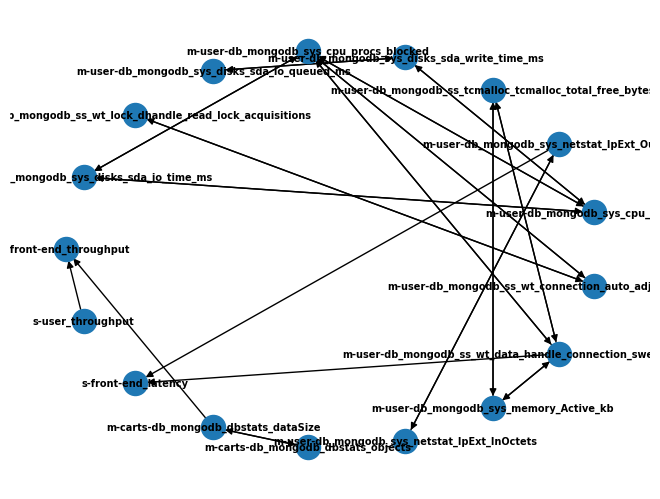

In [50]:
print(datasets_fluxrank_max_cluster[20][0].chaos_case_full())
fixed_cg2 = diag.fix_edge_directions_in_causal_graph(cg2, pk)
nx.draw(fixed_cg2, with_labels=True, font_weight='bold', font_size=7, pos=nx.shell_layout(fixed_cg2))

In [42]:
ranked_record = pagerank(cg, datasets_fluxrank_max_cluster[10][0])
ranked_df = pd.DataFrame(ranked_record, columns=["dataset_id", "target_app", "chaos_type", "chaos_comp", "metric", "time_series", "rank"]).sort_values("rank", ascending=False)
ranked_df

dataset_id target_app      chaos_type chaos_comp  \
2      qknmc  sock-shop  pod-memory-hog     orders   
4      qknmc  sock-shop  pod-memory-hog     orders   
0      qknmc  sock-shop  pod-memory-hog     orders   
1      qknmc  sock-shop  pod-memory-hog     orders   
3      qknmc  sock-shop  pod-memory-hog     orders   
5      qknmc  sock-shop  pod-memory-hog     orders   
6      qknmc  sock-shop  pod-memory-hog     orders   

                                              metric  \
2                m-orders-db_mongodb_sys_cpu_idle_ms   
4                m-orders-db_mongodb_sys_cpu_user_ms   
0                                s-front-end_latency   
1                             s-front-end_throughput   
3  m-orders-db_mongodb_ss_wt_data_handle_connecti...   
5     m-orders-db_mongodb_ss_extra_info_user_time_us   
6                   m-orders-db_mongodb_sys_cpu_ctxt   

                                         time_series      rank  
2  [1795.1667, 1795.1667, 1795.1667, 1795.1667, 1...  0.317275  
4  [127.0, 127.0, 127.0, 127.0, 127.0, 129.8333, ...  0.294482  
0  [0.0098, 0.0101, 0.01, 0.0096, 0.0095, 0.0092,...  0.156238  
1  [38.8444, 38.7778, 39.0667, 39.1111, 39.2889, ...  0.154631  
3  [0.55, 0.55, 0.55, 0.55, 0.55, 0.5167, 0.5167,...  0.027772  
5  [6492.1667, 6492.1667, 6492.1667, 6492.1667, 6...  0.024801  
6  [3926.4333, 3926.4333, 3926.4333, 3926.4333, 3...  0.024801

/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/notebooks/../diagnoser/citest/fisher_z.py:36: RuntimeWarning: invalid value encountered in sqrt
  return -pim[0, 1] / np.sqrt(pim[0, 0] * pim[1, 1])
/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/notebooks/../diagnoser/citest/fisher_z.py:36: RuntimeWarning: invalid value encountered in sqrt
  return -pim[0, 1] / np.sqrt(pim[0, 0] * pim[1, 1])
/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/notebooks/../diagnoser/citest/fisher_z.py:36: RuntimeWarning: invalid value encountered in sqrt
  return -pim[0, 1] / np.sqrt(pim[0, 0] * pim[1, 1])
/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/notebooks/../diagnoser/citest/fisher_z.py:36: RuntimeWarning: invalid value encountered in sqrt
  return -pim[0, 1] / np.sqrt(pim[0, 0] * pim[1, 1])
/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/notebooks/../diagnoser/citest/fisher_z.py:36: RuntimeWarning: invalid value encountered in sqrt
  return -pim[0, 1] / np.sqrt(pim[0, 0] * pim[1,

metric  \
dataset_id target_app chaos_type       chaos_comp                                                                                        
qknmc      sock-shop  pod-network-loss user-db                                                                      s-front-end_errors   
                                       user                                                                          s-user_throughput   
                                       user                                           m-orders_Tomcat_GlobalRequestProcessor_bytesSent   
                                       user                                                         m-orders_counter_status_201_orders   
                                       user                                       m-orders_java_lang_Threading_TotalStartedThreadCount   
                                       user                                                              m-orders_threads_totalStarted   
                                       user                                                       m-orders_Tomcat_Servlet_requestCount   
                                       user                                                           c-orders_cpu_usage_seconds_total   
                                       user                                                   m-orders_Tomcat_WebResourceRoot_hitCount   
                                       user                                                m-orders_Tomcat_WebResourceRoot_lookupCount   
                                       user                                             m-orders_Tomcat_RequestProcessor_bytesReceived   
                                       payment                              m-orders_java_lang_OperatingSystem_OpenFileDescriptorCount   
                                       payment                                    m-orders_Tomcat_GlobalRequestProcessor_bytesReceived   
                                       payment                                           m-orders_Tomcat_ThreadPool_currentThreadsBusy   
                                       payment                               m-orders_java_lang_OperatingSystem_FreePhysicalMemorySize   
                                       payment                                                                        c-orders_threads   
                                       payment                                                  m-orders_Tomcat_WebModule_requestCount   
                                       payment                              m-orders_Tomcat_RequestProcessor_lastRequestProcessingTime   
                                       payment                                                  m-orders_Tomcat_RequestProcessor_stage   
                                       payment                                         m-orders_Tomcat_ProtocolHandler_connectionCount   
                                       payment                                  m-orders_Tomcat_RequestProcessor_requestProcessingTime   
                                       orders-db                                                                    s-carts_throughput   
                                       orders-db                                                                 s-shipping_throughput   
                                       orders-db                                      m-orders-db_mongodb_ss_extra_info_system_time_us   
                                       orders-db                                                                s-front-end_throughput   
                                       orders-db                                                  m-orders-db_mongodb_top_insert_count   
                                       orders-db                                                                   s-front-end_latency   
                                       catalogue-db                                               m-carts-db_mongodb_sys_cpu_i

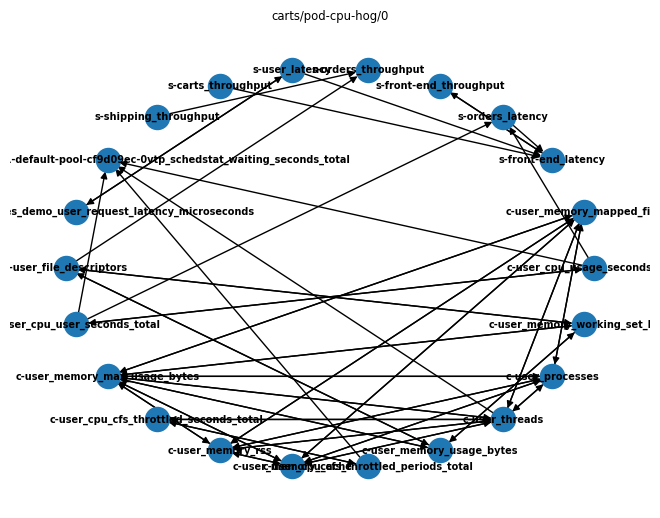

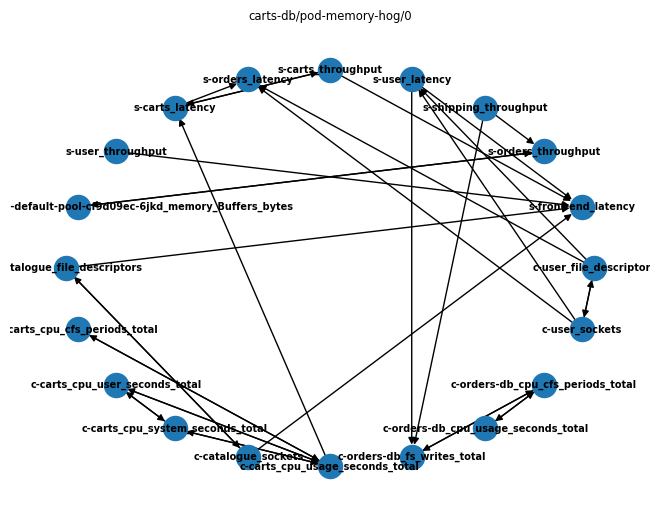

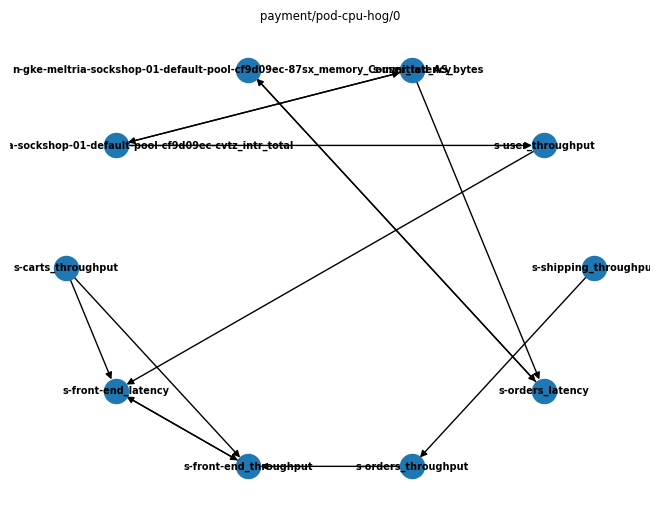

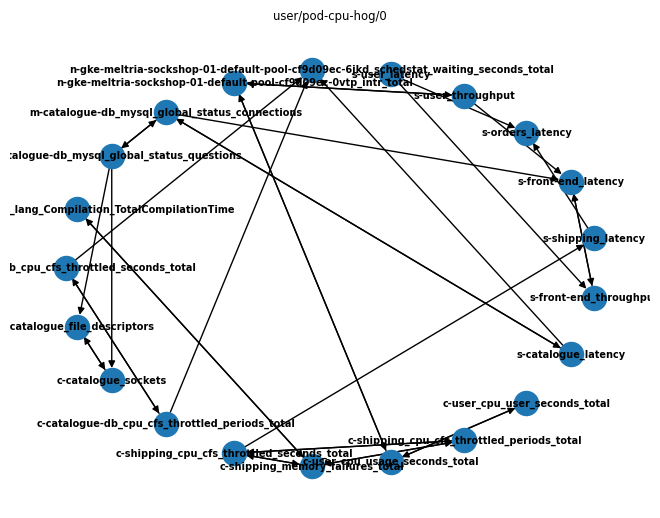

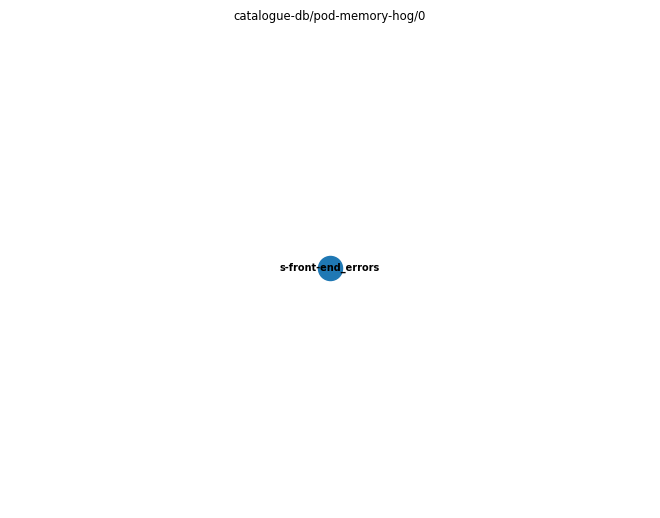

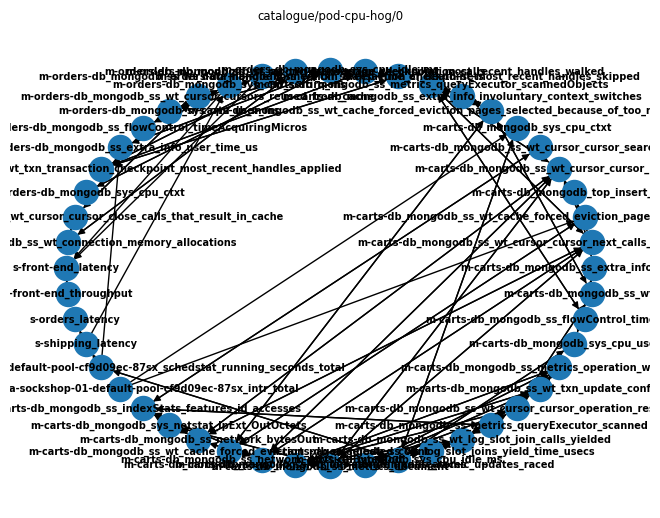

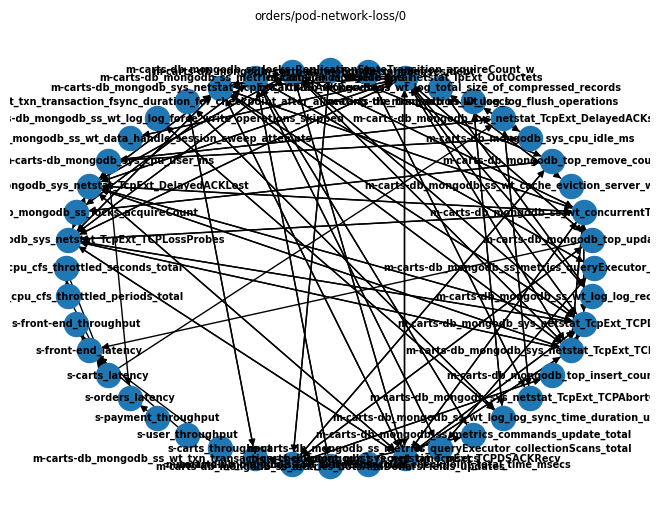

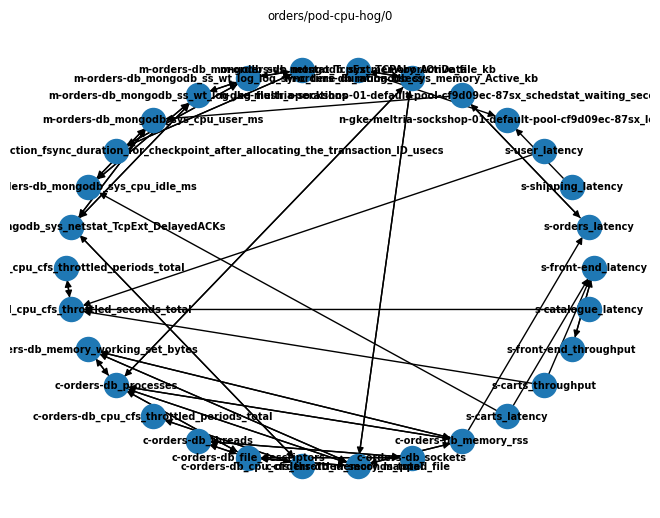

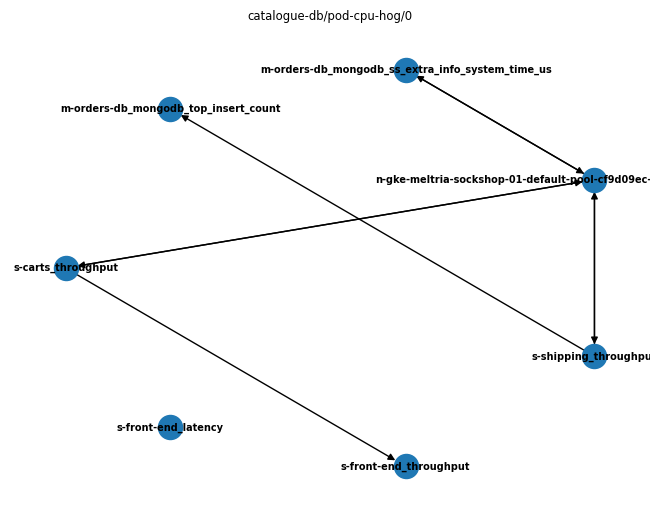

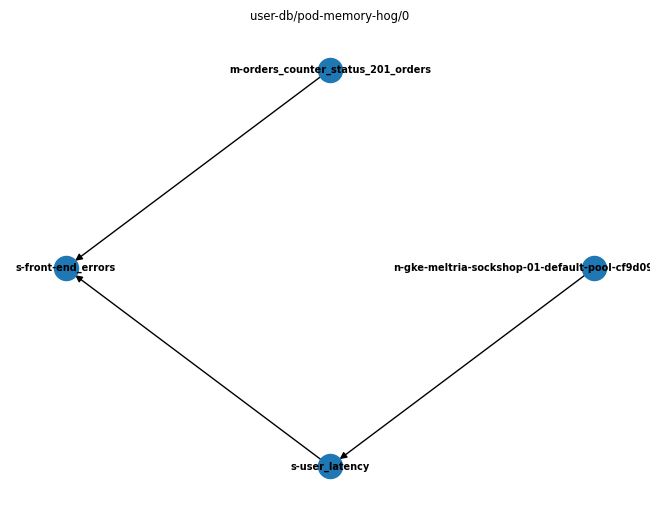

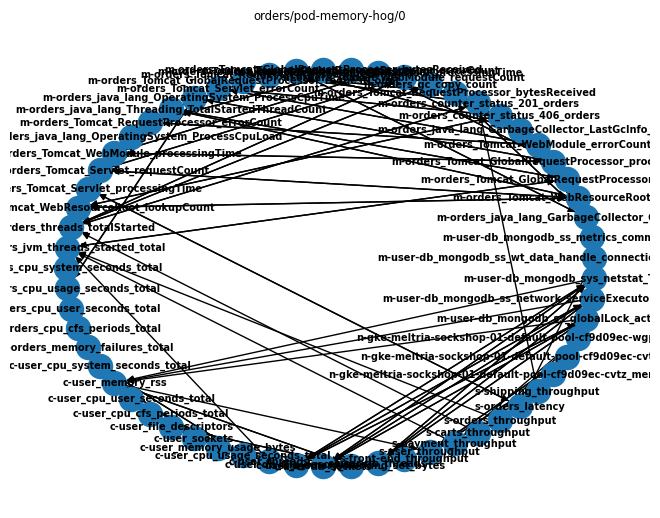

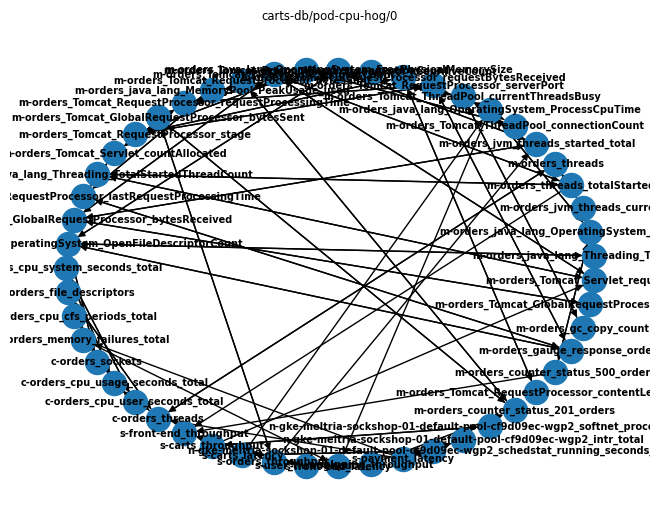

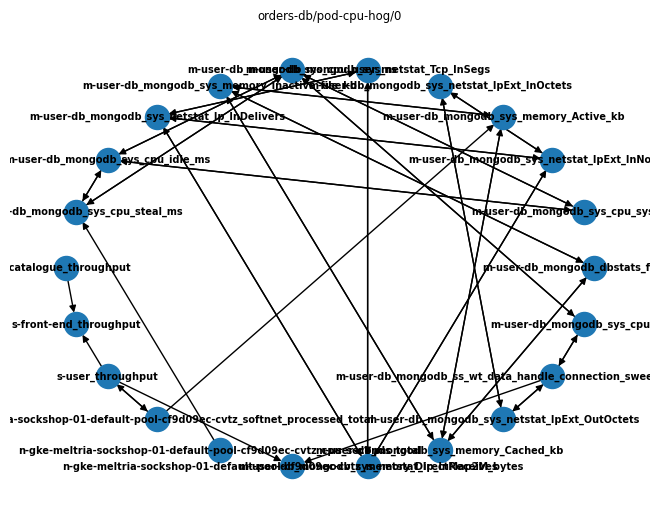

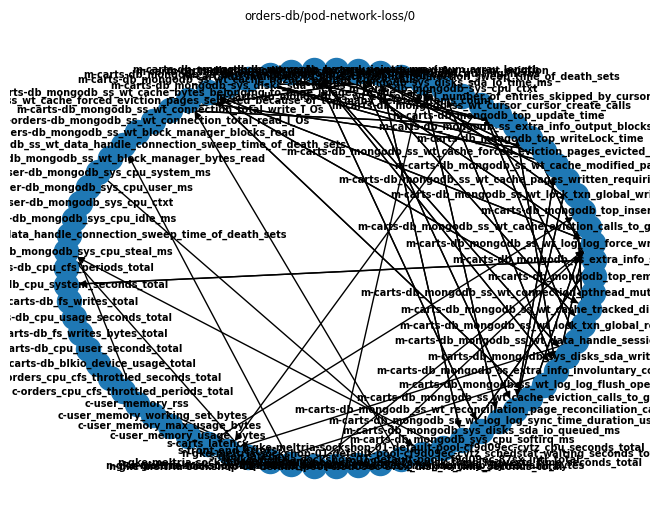

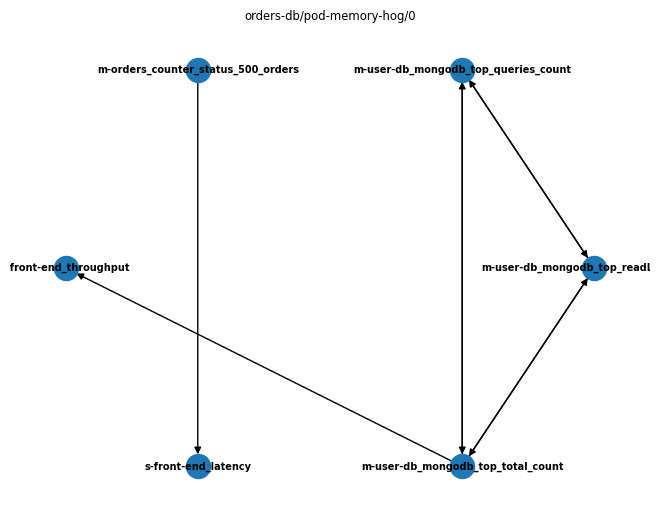

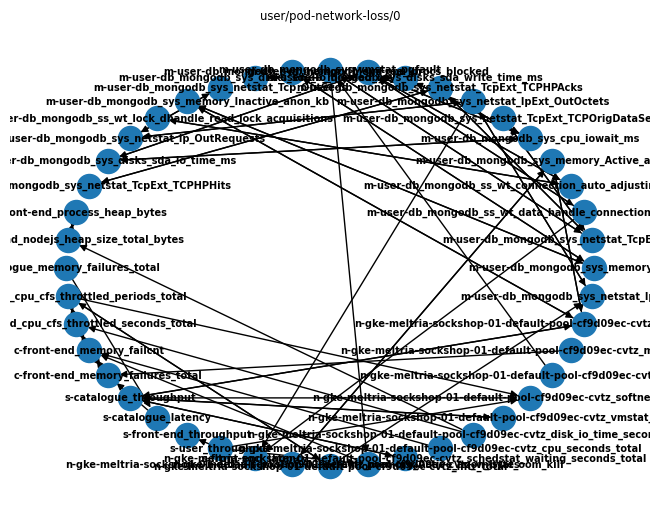

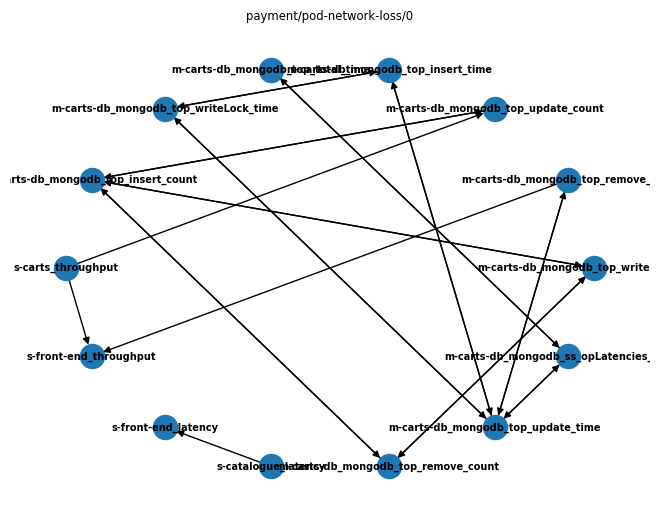

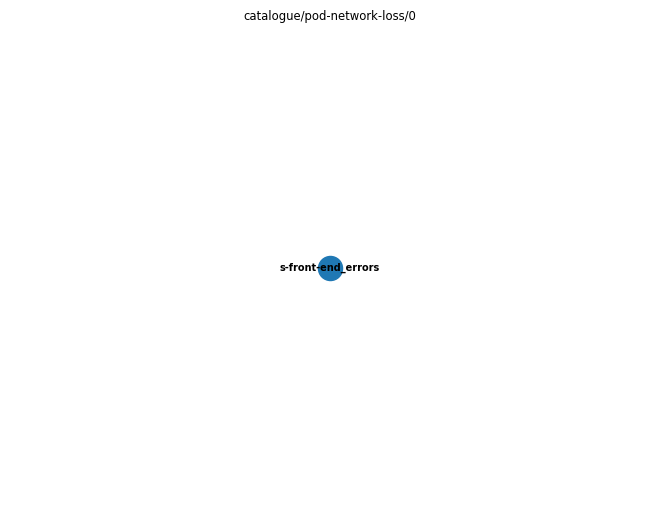

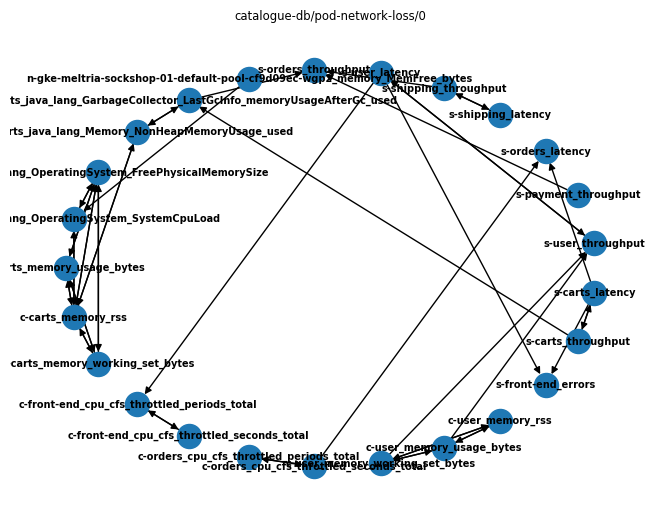

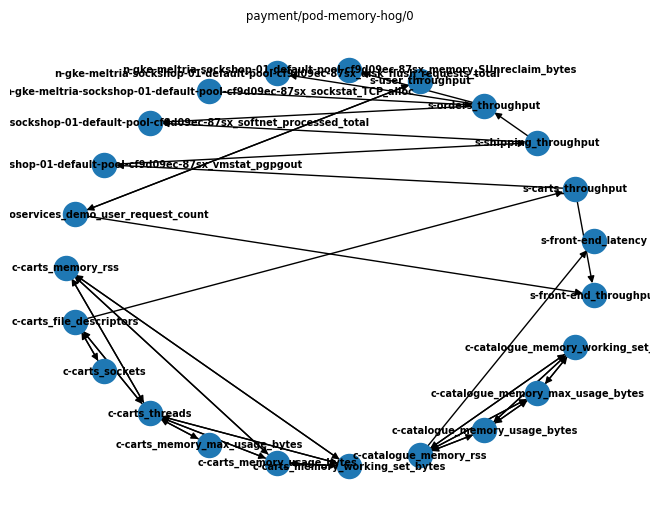

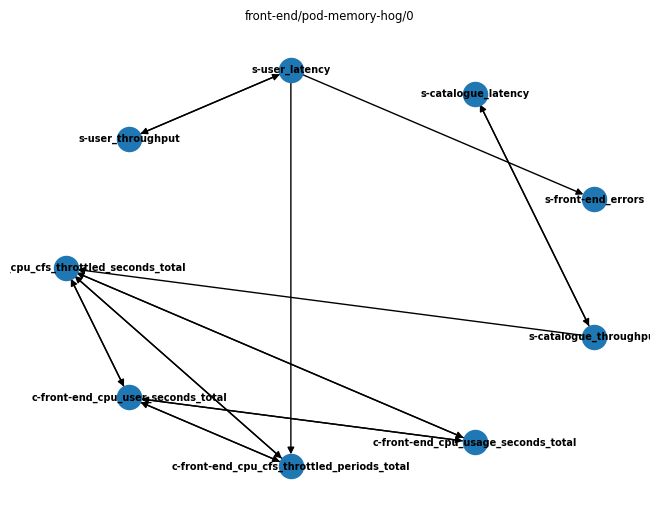

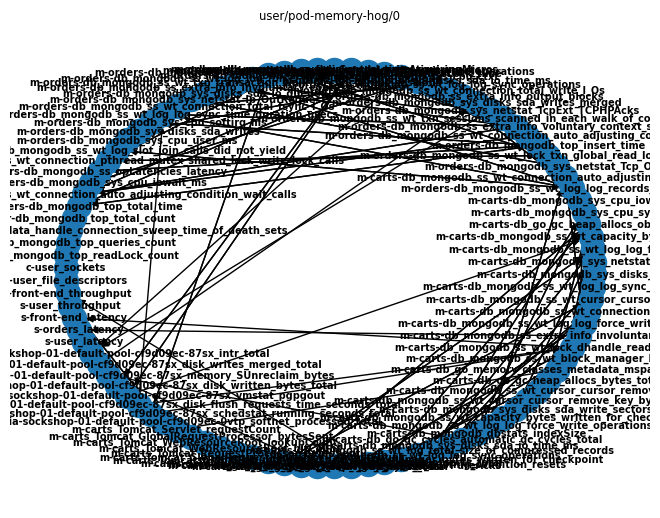

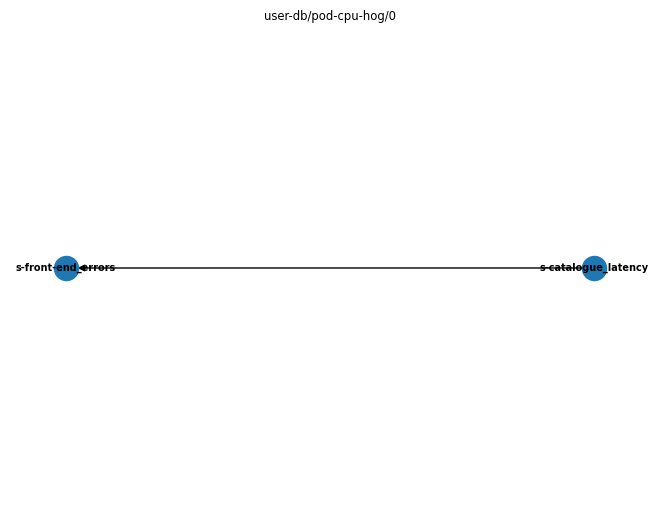

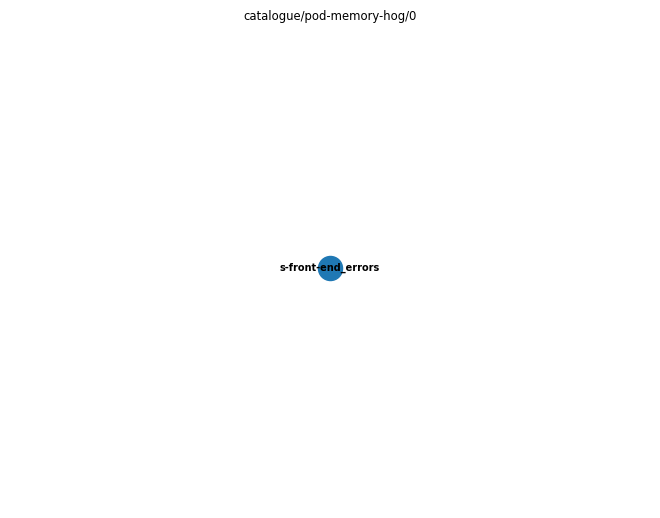

<Figure size 640x480 with 0 Axes>

In [78]:
import joblib

# fast: datasets_fluxrank_max_cluster[3:6] + datasets_fluxrank_max_cluster[8:9]

_list_of_records = joblib.Parallel(n_jobs=-1)(joblib.delayed(build_pc_and_pagerank)(record, reduced_df, ci_alpha=0.10) for record, _, anomalous_df, reduced_df in datasets_fluxrank_max_cluster[3:6] + datasets_fluxrank_max_cluster[8:])
# Get first element of list of tuples.
ranked_datasets = sum([x[1] for x in _list_of_records], [])  # flatten

ranked_df = pd.DataFrame(ranked_datasets, columns=["dataset_id", "target_app", "chaos_type", "chaos_comp", "metric", "time_series", "rank"])
sorted_results_df = ranked_df.query("not metric.str.startswith('n-')", engine='python').loc[:, ranked_df.columns != "time_series"].dropna(subset=["rank"]).sort_values(["dataset_id", "target_app", "chaos_type", "chaos_comp", "rank"], ascending=False).groupby(["dataset_id", "target_app", "chaos_type", "chaos_comp"])
with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None):
    display(sorted_results_df.head(n=10).set_index(["dataset_id", "target_app", "chaos_type", "chaos_comp"]))

for (record, _, _, _), (cg, _) in zip(datasets_fluxrank_max_cluster, _list_of_records):
    nx.draw(cg, with_labels=True, font_weight='bold', font_size=7, pos=nx.shell_layout(cg))
    plt.title(record.chaos_case_full())
    plt.figure()

In [6]:
from notebooklib.save import run_tsdr, save_tsdr, load_tsdr

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [34]:
DATASET_ID = "9n6mf"
datasets_fluxrank_max_cluster2 = load_tsdr(
    DATASET_ID, suffix="", revert_normalized_time_series=True,
    metric_types={"containers": True, "services": True, "middlewares": False, "nodes": False},
)

In [35]:
import multiprocessing
import functools

# https://github.com/joblib/joblib/pull/366#issuecomment-267603530
def with_timeout(timeout):
    def decorator(decorated):
        @functools.wraps(decorated)
        def inner(*args, **kwargs):
            pool = multiprocessing.pool.ThreadPool(1)
            async_result = pool.apply_async(decorated, args, kwargs)
            try:
                return async_result.get(timeout)
            except multiprocessing.TimeoutError:
                record = args[0]
                print(f"Timeouted {record.chaos_case_full()}")
                pool.terminate()
                return
        return inner
    return decorator

@with_timeout(60*3) # 3min
def build_pc_and_pagerank_with_timeout(record, data_df, ci_alpha):
    return build_pc_and_pagerank(record, data_df, ci_alpha)

In [36]:
import joblib

_list_of_records = joblib.Parallel(n_jobs=-1)(joblib.delayed(build_pc_and_pagerank_with_timeout)(record, reduced_df, ci_alpha=0.10) for record, _, anomalous_df, reduced_df in datasets_fluxrank_max_cluster2)
# Get first element of list of tuples.
ranked_datasets = sum([x[1] for x in _list_of_records if x is not None], [])  # flatten

In [37]:
ranked_df = pd.DataFrame(ranked_datasets, columns=["dataset_id", "target_app", "chaos_type", "chaos_comp", "chaos_case_num", "metric", "time_series", "rank"])
sorted_results_df = ranked_df.query("not metric.str.startswith('n-')", engine='python').loc[:, ranked_df.columns != "time_series"].dropna(subset=["rank"]).sort_values(["dataset_id", "target_app", "chaos_type", "chaos_comp", "chaos_case_num", "rank"], ascending=False).groupby(["dataset_id", "target_app", "chaos_type", "chaos_comp", "chaos_case_num"])
with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None):
    display(sorted_results_df.head(n=10).set_index(["dataset_id", "target_app", "chaos_type", "chaos_comp", "chaos_case_num"]))

metric  \
dataset_id target_app chaos_type     chaos_comp   chaos_case_num                                                   
9n6mf      sock-shop  pod-memory-hog user-db      4                                           s-front-end_errors   
                                                  2                          c-front-end_cpu_usage_seconds_total   
                                                  2                            c-front-end_memory_failures_total   
                                                  2                                       s-catalogue_throughput   
                                                  2                                          c-front-end_sockets   
                                                  2                                            s-user_throughput   
                                                  2                         c-catalogue_memory_working_set_bytes   
                                                  2                          c-catalogue_cpu_usage_seconds_total   
                                                  2                                       c-front-end_memory_rss   
                                                  2                                           s-front-end_errors   
                                                  2                                     c-catalogue-db_last_seen   
                                                  1                                           s-front-end_errors   
                                                  1                             c-orders_cpu_usage_seconds_total   
                                                  1                                            s-user_throughput   
                                                  1                     c-orders_cpu_cfs_throttled_periods_total   
                                                  1                         c-front-end_cpu_system_seconds_total   
                                                  1                               c-user_cpu_usage_seconds_total   
                                                  1                            c-user-db_cpu_usage_seconds_total   
                                                  0                                     c-front-end_memory_cache   
                                                  0                                        c-front-end_last_seen   
                                                  0                                           s-front-end_errors   
                                                  0                                             s-orders_latency   
                                                  0                                 c-front-end_file_descriptors   
                                                  0                                            s-user_throughput   
                                                  0                             c-front-end_fs_reads_bytes_total   
                                                  0                                    c-user_memory_usage_bytes   
                                                  0                                       s-catalogue_throughput   
                                                  0                         c-front-end_memory_working_set_bytes   
                                     user         3                          c-front-end_cpu_usage_seconds_total   
                                                  3                               c-front-end_memory_usage_bytes   
                                                  3                            c-front-end_cpu_cfs_periods_total   
                                                  3                                           s-front-end_errors   
                                                  3                                       s-catalogue_throughput   
                                              

In [38]:
from eval.localizaiton_score import evaluate_ac_of_rc

with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None, "display.precision", 2):
    display(
        pd.concat([
            evaluate_ac_of_rc(sorted_results_df, pk, k=10, granuallity="metric"),
            evaluate_ac_of_rc(sorted_results_df, pk, k=10, granuallity="container"),
            evaluate_ac_of_rc(sorted_results_df, pk, k=10, granuallity="service"),
        ], axis=1)
    )

no cause metrics: 9n6mf, sock-shop, pod-cpu-hog, carts
no cause metrics: 9n6mf, sock-shop, pod-cpu-hog, carts-db
no cause metrics: 9n6mf, sock-shop, pod-cpu-hog, carts-db
no cause metrics: 9n6mf, sock-shop, pod-cpu-hog, catalogue
no cause metrics: 9n6mf, sock-shop, pod-cpu-hog, catalogue
no cause metrics: 9n6mf, sock-shop, pod-cpu-hog, catalogue
no cause metrics: 9n6mf, sock-shop, pod-cpu-hog, catalogue-db
no cause metrics: 9n6mf, sock-shop, pod-cpu-hog, catalogue-db
no cause metrics: 9n6mf, sock-shop, pod-cpu-hog, catalogue-db
no cause metrics: 9n6mf, sock-shop, pod-cpu-hog, orders
no cause metrics: 9n6mf, sock-shop, pod-cpu-hog, orders
no cause metrics: 9n6mf, sock-shop, pod-cpu-hog, orders-db
no cause metrics: 9n6mf, sock-shop, pod-cpu-hog, orders-db
no cause metrics: 9n6mf, sock-shop, pod-cpu-hog, payment
no cause metrics: 9n6mf, sock-shop, pod-cpu-hog, user
no cause metrics: 9n6mf, sock-shop, pod-cpu-hog, user-db
no cause metrics: 9n6mf, sock-shop, pod-cpu-hog, user-db
no cause me

AC@K (metric)  AVG@K (metric)  AC@K (container)  AVG@K (container)  \
1            0.05            0.05              0.02               0.02   
2            0.14            0.09              0.03               0.03   
3            0.23            0.14              0.05               0.03   
4            0.32            0.18              0.08               0.05   
5            0.36            0.22              0.08               0.05   
6            0.36            0.24              0.08               0.06   
7            0.41            0.27              0.08               0.06   
8            0.45            0.29              0.08               0.07   
9            0.55            0.32              0.08               0.07   
10           0.55            0.34              0.08               0.07   

    AC@K (service)  AVG@K (service)  
1             0.02             0.02  
2             0.05             0.03  
3             0.10             0.06  
4             0.10             0.07  
5             0.12             0.08  
6             0.12             0.08  
7             0.12             0.09  
8             0.12             0.09  
9             0.12             0.10  
10            0.12             0.10

In [39]:
# for (record, _, _, _), (cg, _) in zip(datasets_fluxrank_max_cluster, _list_of_records):
#     nx.draw(cg, with_labels=True, font_weight='bold', font_size=7, pos=nx.shell_layout(cg))
#     plt.title(record.chaos_case_full())
#     plt.figure()